# 猫狗大战
1是dog，0是cat

In [22]:
import os
import cv2
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

import PIL
from PIL import Image
TRAIN_DIR = '/Users/hehongwei/datas/Cat_Dog/train/'
TEST_DIR = '/Users/hehongwei/datas/Cat_Dog/test/'

In [26]:
ROWS = 224
COLS = 224
CHANNELS = 3

# os.listdir(TRAIN_DIR)
train_images = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)][1:]
train_dogs = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images = [TEST_DIR + i for i in os.listdir(TEST_DIR)][1:]

train_images = train_dogs[0:1000] + train_cats[0:1000]
test_images = test_images[0:50]

train_labels = np.array([1]*1000+[0]*1000)

In [29]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS))

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float32)
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        image_data = np.array(image, dtype=np.float32)
        # norm
        image_data[:,:,0] = (image_data[:,:,0].astype(float) - 255.0/2)/255.0
        image_data[:,:,1] = (image_data[:,:,1].astype(float) - 255.0/2)/255.0
        image_data[:,:,2] = (image_data[:,:,2].astype(float) - 255.0/2)/255.0
        data[i] = image_data.T
        if i % 250 == 0:
            print 'processed {} of {}'.format(i, count)
    return data

train = prep_data(train_images)
test = prep_data(test_images)
print 'Train shape: {}'.format(train.shape)
print 'test shape: {}'.format(test.shape)

processed 0 of 2000
processed 250 of 2000
processed 500 of 2000
processed 750 of 2000
processed 1000 of 2000
processed 1250 of 2000
processed 1500 of 2000
processed 1750 of 2000
processed 0 of 50
Train shape: (2000, 3, 224, 224)
test shape: (50, 3, 224, 224)


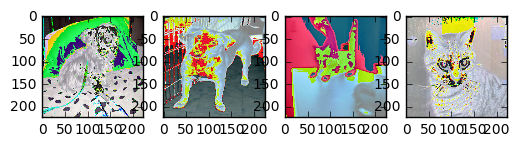

In [21]:
plt.subplot(1,4,1)
plt.imshow(train[0].T)
plt.subplot(1,4,2)
plt.imshow(train[1].T)
plt.subplot(1,4,3)
plt.imshow(train[1000].T)
plt.subplot(1,4,4)
plt.imshow(train[1001].T)

In [5]:
np.random.seed(133)
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset_rand, train_labels_rand = randomize(train, train_labels)
# split
valid_dataset = train_dataset_rand[:400]
valid_labels = train_labels_rand[:400]

train_dataset = train_dataset_rand[400:2000]
train_labels = train_labels_rand[400:2000]

print 'Train', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape

Train (1600, 3, 224, 224) (1600,)
Validation (400, 3, 224, 224) (400,)


## 构建卷积网络

In [7]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

model = Sequential()
# 32个3*3的卷积核，输入图像为3*ROWS*COLS，激活函数为relu
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
# 池化，降采样， 就是用一个值代替一块区域，这个值可以是区域的平均值，最大值，最小值等，目的就是减少数据量
# Maxpooling取2*2矩阵中最大的值代表特征，经过降采样后，原本64*64的举证只有32*32了
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加64个3*3的卷积核
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加128个3*3的卷积核
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加256个3*3的卷积核
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten 将一个多维矩阵展开，铺平成一个一维的向量。为后面的全连接做准备。
model.add(Flatten())
# 添加第一个神经层，神经元256个
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
# 输出神经层，一个神经元
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

In [9]:
nb_epoch = 10
batch_size = 16

hist = model.fit(train_dataset, train_labels, validation_split=0.25, 
                 nb_epoch=nb_epoch, batch_size=batch_size, verbose=1)

Train on 1200 samples, validate on 400 samples
Epoch 1/10
1200/1200 [==============================] - 129s - loss: 0.6412 - acc: 0.6325 - val_loss: 0.6467 - val_acc: 0.6550
Epoch 2/10
1200/1200 [==============================] - 126s - loss: 0.6232 - acc: 0.6400 - val_loss: 0.6275 - val_acc: 0.6525
Epoch 3/10
1200/1200 [==============================] - 123s - loss: 0.6099 - acc: 0.6508 - val_loss: 0.6306 - val_acc: 0.6700
Epoch 4/10
1200/1200 [==============================] - 127s - loss: 0.5978 - acc: 0.6683 - val_loss: 0.6088 - val_acc: 0.6500
Epoch 5/10
1200/1200 [==============================] - 131s - loss: 0.5722 - acc: 0.7083 - val_loss: 0.5926 - val_acc: 0.6800
Epoch 6/10
1200/1200 [==============================] - 133s - loss: 0.5508 - acc: 0.7100 - val_loss: 0.6130 - val_acc: 0.6500
Epoch 7/10
1200/1200 [==============================] - 140s - loss: 0.5304 - acc: 0.7300 - val_loss: 0.5845 - val_acc: 0.6900
Epoch 8/10
1200/1200 [==============================] - 133s - l

In [10]:
scores = model.evaluate(valid_dataset, valid_labels, verbose=1)

400/400 [==============================] - 12s    


In [11]:
print('Test score:', scores[0])
print('Test accuracy:', scores[1])

('Test score:', 0.54921049594879146)
('Test accuracy:', 0.71750000000000003)


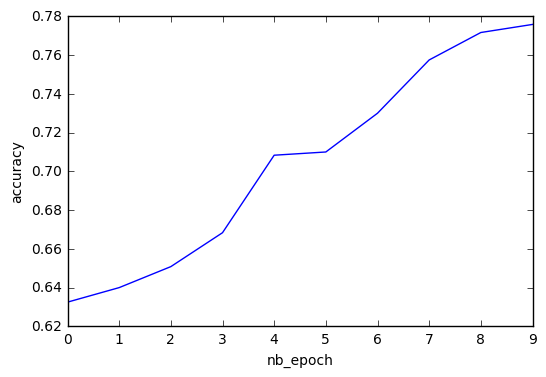

In [12]:
# 可视化一下，看看最后是否收敛
plt.plot(range(len(hist.history['acc'])), hist.history['acc'])
plt.xlabel('nb_epoch')
plt.ylabel('accuracy')
plt.show()

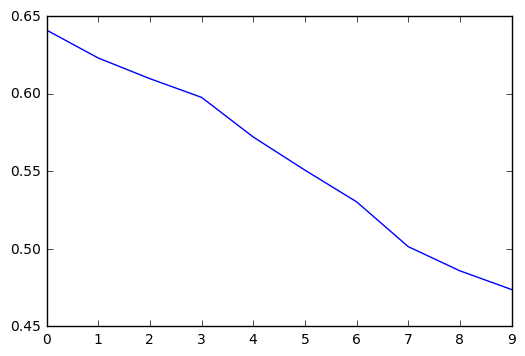

In [13]:
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.show()

In [15]:
predictions = model.predict(valid_dataset, verbose=1)

400/400 [==============================] - 12s    


[ 0.73746675] is a cat


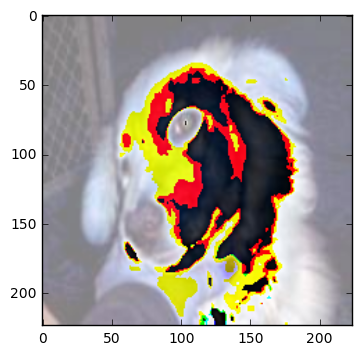

[ 0.864586] is a cat


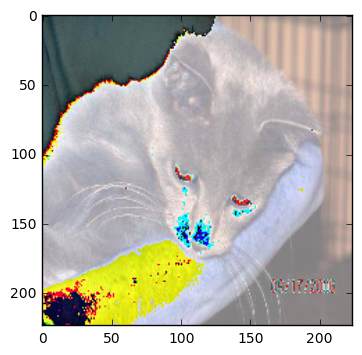

[ 0.57717144] is a cat


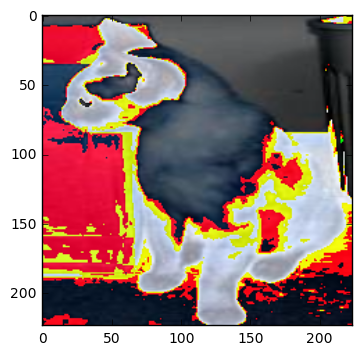

[ 0.91479999] is a dog


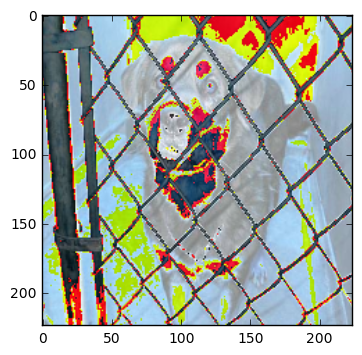

[ 0.75425994] is a cat


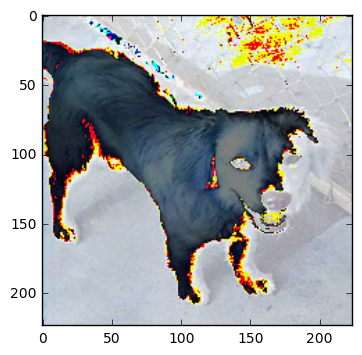

[ 0.92631119] is a cat


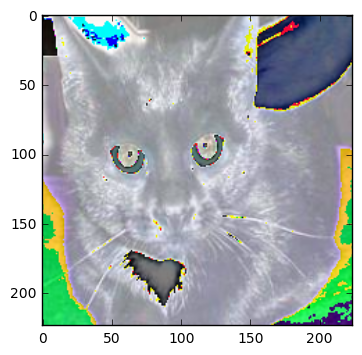

[ 0.91959268] is a cat


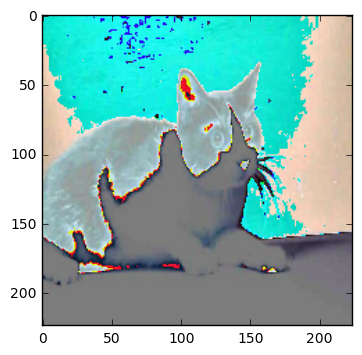

[ 0.53551936] is a cat


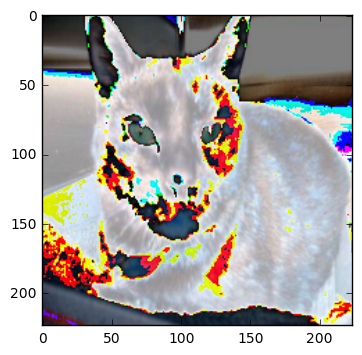

[ 0.63100821] is a dog


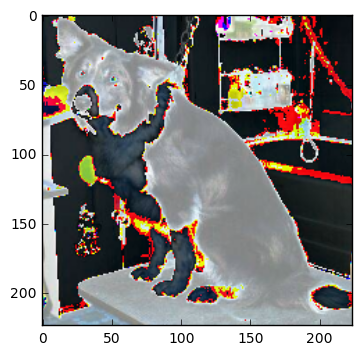

[ 0.72268349] is a dog


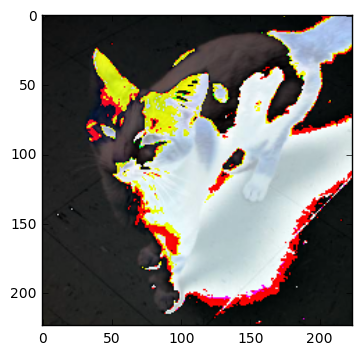

In [17]:
for i in range(10):
    if predictions[i] >= 0.5:
        print predictions[i], 'is a dog'
    else:
        print 1-predictions[i], 'is a cat'
    
    plt.imshow(valid_dataset[i].T)
    plt.show()